# DATA ACQUISITION AND MANIPULATION
Retrieval and shaping of data from the NeedleDrop dataset and Spotify API

### Step 1: Get NeedleDrop Data

In [1]:
#import data science tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-darkgrid')

In [2]:
#Get the NeedleDrop ratings in a pandas DataFrame and manipulate it to bettwe suit our needs
nd = pd.read_csv('./all_needledrop_ratings.csv')

#Set column names
nd.columns = ['artist','album','score','review year']

#drop review year column. This column contains very incomplete data and we can get better data from the spotify API
nd.drop(labels='review year', axis='columns',inplace=True)

#drop first 2 rows
nd.drop(labels=[0,1],axis='index',inplace=True)

#set rating of all albums with rating "classic" or "CLASSIC" to 10
nd.replace(to_replace=['CLASSIC','classic'],value='10', inplace=True)

#remove all rows with weird ratings. For example, we can't assign "meh" a numerical value without guessing and potentially skewing the data
nd = nd[nd['score'].apply(lambda x: x.isdigit())]

#replace scores with numerical data
dic = {'10':10,'9':9,'8':8,'7':7,'6':6,'5':5,'4':4,'3':3,'2':2,'1':1,'0':0}
nd.replace(dic, inplace=True)
nd

,artist,album,score
2,System of a Down,Toxicity,10
3,Burial,Untrue,10
4,Cannibal Ox,The Cold Vein,10
5,Sleater-Kinney,The Woods,10
6,The Postal Service,Give Up,10
...,...,...,...
1991,Broken Bells,Broken Bells,5
1992,Liars,Sisterworld,6
1993,High On Fire,Snakes for the Divine,8
1994,The Knife,Tomorrow In a Year,3


---
The NeedleDrop data is now suitable for analysis, but there isn't much to be learned from this data alone. Here is some basic data exploration that can be done with the NeedleDrop dataset. Beyond this, we need to combine this data with other data.

In [3]:
nd.describe()

,score
count,1858.000000
mean,6.431109
std,1.646079
min,0.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,10.000000


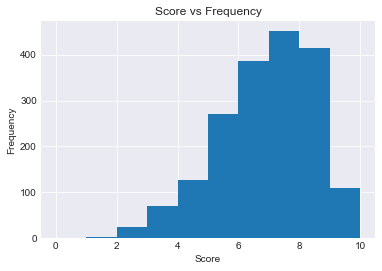

In [4]:
#histogram of scores
plt.hist(nd['score'],bins=10)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Score vs Frequency")
plt.show()

In [5]:
#The NeedleDrop top 10 artists by most frequent appearances
n = 10
top = nd['artist'].value_counts()[:n].index.tolist()
top_artists = pd.DataFrame(columns=['artist','album','score'])
for a in top:
    top_artists = pd.concat([top_artists, nd[nd['artist'] == a]])
top_artists['artist'].value_counts()

Death Grips           8
Various Artists       7
Big K.R.I.T.          7
Logic                 6
The Weeknd            6
of Montreal           5
Vince Staples         5
Kendrick Lamar        5
The Underachievers    5
Mac Miller            5
Name: artist, dtype: int64

### Step 2. Get Spotify Data

In [6]:
#import spotify api client
import csv
from spotify_client import Spotify_client
from album import Album
from db_client import DB_Client
from ipypb import track as pb
from os.path import getsize

In [7]:
# create client
client = Spotify_client()

#gather raw Spotify album data of albums from list of album names included in NeedleDrop data
raw_albums = []
flagged_albums = []
missed_albums = [] #to look for commonalities in missed searches (maybe we can recover some of this data)
print('Gathering raw album data')
#for album, artists in zip(pb(nd['album'].tolist()),nd['artist'].tolist()):
for index, row in pb(nd.iterrows(),len(nd.index)):
    album = row['album']
    artists = row['artist']
    score = row['score']
    
    album = str(album).strip()
    artists = artists.split(", ")
    a_temp = []
    for a in artists:
        a_temp.append(str(a).strip())
    artists = a_temp
    try:
        flag, search = client.search_for_album(album,artists)
        #successful search
        if flag == 0:
            search['score'] = score
            raw_albums.append(search)
        #flagged search (returned album might be incorrect)
        elif flag == -1:
            search['score'] = score
            flagged_albums.append(((album,artists),search))
        #failed search (no album returned matching search query)
        elif flag == -2:
            missed_albums.append((album,artists))
    except Exception as e:
        print('\t',"exception occured during search for", album, "by", artists, ":", str(e))
raw_albums = [a for a in raw_albums if a] 
print(len(raw_albums) + len(flagged_albums) ," raw albums collected")

Gathering raw album data


 [████████████████████████████████████████████████████████████] 1858/1858 [04:03<00:00, 0.13s/it]

1821  raw albums collected


In [8]:
#at this stage, the missed albums either weren't on spotify or had spelling errors
#all spelling errors were corrected
print(len(missed_albums))

37


In [10]:
#There are still some flagged albums after the search algorithm resolves
#This is an optional checker that allows for manual verification of flagged albums
print("input -> search result")
for album in flagged_albums:
    print(album[0][0], "by", album [0][1], "->", album[1]['name'], "by", album[1]['artists'][0]['name'], end=" >> ")
    ans = input ("correct? [y/N]: ")
    while ans != "y" and ans != "N":
        ans = input("invalid input, enter [y/N]: ")
    if ans == "y":
        raw_albums.append(album[1])
        flagged_albums.remove(album)
    else:
        missed_albums.append(album[1])

input -> search result
Magnus by ['Thou'] -> My Love Is Gone (MAGNUS Remix) by Jonas Aden >> 

correct? [y/N]:  N


Tierra Whack by ['Tierra Whack'] -> So Sick So Sad (Tierra Whack "Fuck Off" Bootleg Rmx) by Lil 'Merica >> 

correct? [y/N]:  N


Endless by ['Frank Ocean'] -> Our Endless Numbered Days by Iron & Wine >> 

correct? [y/N]:  N


Godfather II by ['Wiley'] -> The Godfather I, II & III (Piano Version) by Ilary Barnes >> 

correct? [y/N]:  N


8 by ['Hop Along'] -> 8 Letters by Why Don't We >> 

correct? [y/N]:  N


? by ['XXXTENTACION'] -> The Album by Teyana Taylor >> 

correct? [y/N]:  N


Black Panther The Album by ['Various Artists'] -> Black Panther The Album Music From And Inspired By by Kendrick Lamar >> 

correct? [y/N]:  y


Flames Within Flames by ['Neurosis'] -> Flames Within (Radio Edit) by AcroniX >> 

correct? [y/N]:  N


Rain Temple by ['2 8 1 4'] -> December 2019: Rain Recordings For Ultimate Relaxation by White Noise Relaxation >> 

correct? [y/N]:  N


99.90% by ['Kaytranada'] -> First Take Fridays, Vol. 9 (Episodes 90-99) by Jonathan Brader >> 

correct? [y/N]:  N


The Colour In Everything by ['James Blake'] -> The Believer by Everything In Colour >> 

correct? [y/N]:  N


Space Heads by ['VARIOUS ARTISTS'] -> Tuning the Space Remixes by Groove Genies >> 

correct? [y/N]:  N


Product by ['Sophie'] -> The Essential Boogie Down Productions / KRS-One by Boogie Down Productions >> 

correct? [y/N]:  N


Divers by ['Joanna Newsom'] -> Divers by CNC >> 

correct? [y/N]:  N


It's Better This Way by ['Big K.R.I.T.'] -> It's Better This Way by Remote Viewing >> 

correct? [y/N]:  N


The New CALassic by ['Cal Chuchesta'] -> The New Harlem Funk - Gotta Take Your Love (2 Original Classic Albums) by Flowchart >> 

correct? [y/N]:  N


Wave[s] by ['Mick Jenkins'] -> Waves of the Sea, Ocean and Lakes by Ocean Waves For Sleep >> 

correct? [y/N]:  N


Simple Songs by ["Jim O'Rourke"] -> Simple Songs Of Freedom: The Tim Hardin Collection by Tim Hardin >> 

correct? [y/N]:  N


TĂU by ['Negură Bunget'] -> God Taught Me by Zauntee >> 

correct? [y/N]:  N


A Special Episode Of by ['Open Mike Eagle'] -> ASOT 984 - A State Of Trance Episode 984 (Who's Afraid Of 138?! Special) by Armin van Buuren >> 

correct? [y/N]:  N


Viet Cong by ['Viet Cong'] -> Viet-Nam : Théâtre populaire du nord (Hat Cheo) by Hung Dang Cong >> 

correct? [y/N]:  N


The Church by ['Mr. Oizo'] -> Let The Church Say Amen (Radio Edit) by Andrae Crouch >> 

correct? [y/N]:  N


Seeds by ['TVOTR'] -> Seeds by TV On The Radio >> 

correct? [y/N]:  N


Rhythm by ['Wildbirds & Peacedrums'] -> People's Instinctive Travels and the Paths of Rhythm (25th Anniversary Edition) by A Tribe Called Quest >> 

correct? [y/N]:  N


INSA by ['Mellowhype'] -> Alphabet Insanity 2 by Mac Lethal >> 

correct? [y/N]:  N


No More by ['Shlohmo & Jeremih'] -> Nothing More by Nothing More >> 

correct? [y/N]:  N


Faces by ['Mac Miller'] -> The Best of Faces: Good Boys When They're Asleep by Faces >> 

correct? [y/N]:  N


Christmas Island by ['Andrew Jackson Jihad'] -> Christmas Island by Leon Redbone >> 

correct? [y/N]:  N


P.T.S.D. by ['Pharoahe Monch'] -> Sleeping Music: Calm Music to Help You Sleep, Natural Sleep Aid and Relaxing Piano for Sleep Music by Deep Sleep Music Collective >> 

correct? [y/N]:  N


Blue Chips 2 by ['Action Bronson & Party Supplies'] -> Blue and White - 2013 by The Buffalo Chips >> 

correct? [y/N]:  N


BetterOffDEAD by ['Flatbush Zombies'] -> Betteroffdead. by sushimusor >> 

correct? [y/N]:  N


GNK by ['YC The Cynic'] -> DoD (GnkMix) by GB Lotto >> 

correct? [y/N]:  N


Endless Night by ['TOAD'] -> Endless Night by Kent Loon >> 

correct? [y/N]:  N


Kismet by ["Mr. Muthafuckin' eXquire"] -> Kismet by Buddha Trixie >> 

correct? [y/N]:  N


Howl by ['This Routine Is Hell'] -> Howlin' Wolf by Howlin' Wolf >> 

correct? [y/N]:  N


The Eulogy by ['Cakes Da Killa'] -> The Eulogy by Dj Magicmike-Spud >> 

correct? [y/N]:  N


Floral Shoppe by ['Macintosh Plus'] -> Floral Shoppe 2 by THE DARKEST FUTURE >> 

correct? [y/N]:  N


Duality by ['Captain Murphy'] -> DUALITY by WE ARE FURY >> 

correct? [y/N]:  N


(III) by ['Crystal Castles'] -> Revenge Of The Dreamers III by Dreamville >> 

correct? [y/N]:  N


3rd by ['Hoax'] -> EX'ACT - The 3rd Album by EXO >> 

correct? [y/N]:  N


Lord$ Never Worry by ['A$AP Mob'] -> Lords Never Worry by Pageant Queen >> 

correct? [y/N]:  N


Instinct by ['Niki and the Dove'] -> Ultra Instinct Mastered by Friedrich Habetler >> 

correct? [y/N]:  N


No Idols by ['Domo Genesis'] -> No False Idols, Chapter 1 by Neo Fresco >> 

correct? [y/N]:  N


Hair by ['Ty Segall & White Fence'] -> Bad Hair Day by "Weird Al" Yankovic >> 

correct? [y/N]:  N


Americana by ['Neil Young & Crazy Horse'] -> Americana by Gregoire Maret >> 

correct? [y/N]:  N


Cancer for Cure by ['El-P'] -> Cure For Cancer by Meezzy Trappo >> 

correct? [y/N]:  N


R.A.P. Music by ['Killer Mike'] -> Sleeping Music: Calm Music to Help You Sleep, Natural Sleep Aid and Relaxing Piano for Sleep Music by Deep Sleep Music Collective >> 

correct? [y/N]:  N


OFF! by ['OFF!'] -> Better off Dead by Josh A >> 

correct? [y/N]:  N


Dweller On the Threshold by ['Dweller On the Threshold'] -> The Dweller on the Threshold by Starbirthed >> 

correct? [y/N]:  N


Narrow by ['Soap&Skin'] -> Chutes Too Narrow by The Shins >> 

correct? [y/N]:  N


Kings and Them by ['Evian Christ'] -> Humperdinck - Sleeping Beauty - Excerpts From 'Kings Children' - Fantasy On A Theme From 'Hansel And Gretel' by Engelbert Humperdinck >> 

correct? [y/N]:  N


When You're Gone by ['Lapalux'] -> When You're Gone by Jalal Aliniya >> 

correct? [y/N]:  N


I.V. by ['Loma Prieta'] -> Luv Is Rage 2 by Lil Uzi Vert >> 

correct? [y/N]:  N


The Horror by ['Pop. 1280'] -> Getting There From Here (with Todd Edwards) (Miami Horror & Lazywax Remix) by Poolside >> 

correct? [y/N]:  N


Echoes of Silence by ['The Weeknd'] -> Echoes Of Silence by Thierry Lang >> 

correct? [y/N]:  N


Live. Love. A$AP by ['ASAP Rocky'] -> Wondrous Love (Live) by BYU Women's Chorus >> 

correct? [y/N]:  N


Knife Man by ['Andrew Jackson Jihad'] -> Knife by Manos Fikapa >> 

correct? [y/N]:  N


Room(s) by ['Machinedrum'] -> Room For Squares by John Mayer >> 

correct? [y/N]:  N


Lover's Holiday by ['Theophilus London'] -> Lover's Holiday by Stephanie Cooke >> 

correct? [y/N]:  N


R.E.K.S. by ['Reks'] -> Mozart's Eine Kleine Nachtmusik 4th M. (Rondo) by Wolfgang Amadeus Mozart >> 

correct? [y/N]:  N


Unlearn by ['Fergus & Geronimo'] -> Learning How to Unlearn by Dogtooth & Nail >> 

correct? [y/N]:  N


Kills by ['jj'] -> Addiction Kills by Jelly Roll >> 

correct? [y/N]:  N


Bastard by ['Tyler', 'The Creator'] -> "God, Forgive These Bastards" Songs From The Forgotten Life of Henry Turner by The Taxpayers >> 

correct? [y/N]:  N


First Four by ['Off!'] -> First Family 4 Life by M.O.P. >> 

correct? [y/N]:  N


All Day by ['Girl Talk'] -> Father of All... by Green Day >> 

correct? [y/N]:  N


Maya (/\/\ /\ Y /\) by ['MIA'] -> Migz & Maya by Migz & Maya >> 

correct? [y/N]:  N


Pomegranates by ['Various Artists'] -> Winter Pomegranates by Patrice Ruane >> 

correct? [y/N]:  N


Go by ['Jonsi'] -> It Was Good Until It Wasn't by Kehlani >> 

correct? [y/N]:  N


In [8]:
#prepare CSV to hold album information
ndcsv = 'needledrop_data.csv'
csvids = set()
cols = []
ndd = open(ndcsv, "a")
if getsize(ndcsv) == 0:
    alb = Album(raw_albums[0],client)
    alb.dataframe()
    df = alb.df.describe()
    df.drop(labels=['count','min','max','25%','75%'], axis='index', inplace=True)
    cols = ['id','album','score','artists','year','track count','duration']
    #get column names
    for row in df.index.values.tolist():
        for col in df.columns:
            cols.append(col + " " + row)
            
    wr = csv.writer(ndd, dialect='excel')
    wr.writerow(cols)
    ndd.close()
        
    
else:
    ndd.close()
    #get set of unique id's already loaded into csv
    with open(ndcsv, "r", encoding = "utf-8") as ndd:
        reader = csv.reader(ndd)
        for line in reader:
            if line and line[0] != 'id':
                csvids.add(line[0])

In [8]:
#this is a substitute cell for the cell above meant to keep track of 
#which albums have been placed in the database. For regular usage run the cell above instead of this one
ndcsv = 'database_ids.csv'
csvids = set()
cols = ['id']
ndd = open(ndcsv, "a")
if getsize(ndcsv) == 0:
    wr = csv.writer(ndd, dialect='excel')
    wr.writerow(cols)
    ndd.close()
else:
    ndd.close()
    with open(ndcsv, "r", encoding = "utf-8") as ndd:
        reader = csv.reader(ndd)
        for line in reader:
            if line and line[0] != 'id':
                csvids.add(line[0])

In [9]:
#prepare database to hold song/artist/album data
#login
db = DB_Client()


Username:  jaxonmcneil


Password: 

 ················


In [11]:
#run this block to rebuild the schema
print("WARNING, RUNNING THIS WILL DELETE THE SCHEMA")
answer = input("CONFIRM? (y/n): ")
if answer == 'y':
        db.refresh_tables()
        print("schema restarted!")

WARNING, RUNNING THIS WILL DELETE THE SCHEMA


CONFIRM? (y/n):  n


In [10]:
# initialize albums and tracks, summarize, and put in CSV for storage
#albums = []
print("initializing albums and tracks")
i = 0
with open(ndcsv, "a", encoding="utf-8") as ndd:
    wr = csv.writer(ndd, dialect='excel')
    for raw_album in pb(raw_albums):
        i += 1
        try:
            #albums.append(Album(raw_album, client))
            ''' This is the original code block
            if raw_album['id'] not in csvids:
                album = Album(raw_album,client)
                wr.writerow(album.summary)
                csvids.add(album.id)
            if i%10 == 0:
                ndd.flush()
            ''' 
            #This is the code bloack for bul loading the data to the database
            if raw_album['id'] not in csvids:
                album = Album(raw_album, client)
                db.insert_album(album)
                wr.writerow([album.id])
                csvids.add(album.id)
            if i%10 == 0:
                ndd.flush()
        except Exception as e:
            print("exception occured during initialization of " + raw_album['name'] + ": " + str(e)) 
print(len(csvids), "albums initialized")

initializing albums and tracks


 [████████████████████████████████████████████████████████████] 1748/1748 [24:31<00:13, 0.84s/it]

Soused by Scott [█████████####################################] 1/5 [00:01<00:01, 0.89s/it]

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5C4fIPZukzNltyO9pBz148 returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5C4fIPZukzNltyO9pBz148 returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5C4fIPZukzNltyO9pBz148 returned 404 due to analysis not found


exception occured during initialization of Soused: local variable 'analysis' referenced before assignment


Trilogy by The  [█████████████████████████████████████████████] 30/30 [00:21<00:01, 0.71s/it]

Nine Types of L [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.70s/it]

Creep On Creepi [█████████████████████████████████████████████] 10/10 [00:07<00:00, 0.65s/it]

What Did You Ex [█████████████████████████████████████████████] 12/12 [00:07<00:00, 0.58s/it]

Holy Ghost! by  [█████████████████████████████████████████████] 10/10 [00:09<00:01, 0.86s/it]

Tomboy by Panda [█████████████████████████████████████████████] 11/11 [00:07<00:00, 0.61s/it]

Darker Handcraf [█████████████████████████████████████████████] 12/12 [00:07<00:01, 0.62s/it]

Mind Bokeh by B [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.71s/it]

Idle Labor by C [█████████████████████████████████████████████] 11/11 [00:06<00:01, 0.59s/it]

Belong by The P [█████████████████████████████████████████████] 10/10 [00:05<00:01, 0.55s/it]

Angles by The S [█████████████████████████████████████████████] 10/10 [00:06<00:00, 0.59s/it]

Fallen by Burzu [█████████████████████████████████████████████] 7/7 [00:07<00:01, 0.95s/it]

Shaolin Vs. Wu- [█████████████████████████████████████████████] 17/17 [00:11<00:00, 0.65s/it]

Lasers by Lupe  [█████████████████████████████████████████████] 12/12 [00:07<00:01, 0.61s/it]

Ravedeath, 1972 [█████████████████████████████████████████████] 12/12 [00:07<00:01, 0.55s/it]

Jason... The Dr [█████████████████████████████████████████████] 10/10 [00:05<00:01, 0.48s/it]

Different Gear, [█████████████████████████████████████████████] 13/13 [00:08<00:01, 0.65s/it]

All Eternals De [█████████████████████████████████████████████] 13/13 [00:09<00:01, 0.71s/it]

Mosaik by Siriu [█████████████████████████████████████████████] 17/17 [00:10<00:01, 0.61s/it]

   Yuck by Yuck [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.66s/it]

Higher Learning [█████████████████████████████████████████████] 13/13 [00:09<00:01, 0.72s/it]

Let England Sha [█████████████████████████████████████████████] 13/13 [00:07<00:01, 0.55s/it]

Underneath The  [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.63s/it]

New History War [█████████████████████████████████████████████] 14/14 [00:09<00:00, 0.63s/it]

The King Of Lim [█████████████████████████████████████████████] 8/8 [00:06<00:01, 0.77s/it]

Space Is Only N [█████████████████████████████████████████████] 13/13 [00:07<00:01, 0.56s/it]

     V by Vreid [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.69s/it]

Angels Exodus b [█████████████████████████████████████████████] 12/12 [00:07<00:00, 0.59s/it]

Hardcore Will N [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.62s/it]

Natural Child b [█████████████████████████████████████████████] 11/11 [00:06<00:01, 0.56s/it]

feel away (feat [█████████████████████████████████████████████] 1/1 [00:03<00:03, 2.92s/it]

Zonoscope by Cu [█████████████████████████████████████████████] 11/11 [00:11<00:01, 1.00s/it]

Angels Of Darkn [█████████████████████████████████████████████] 5/5 [00:04<00:01, 0.80s/it]

Elephants At Th [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.67s/it]

White Wildernes [█████████████████████████████████████████████] 9/9 [00:04<00:01, 0.49s/it]

Native Speaker  [█████████████████████████████████████████████] 9/9 [00:07<00:01, 0.76s/it]

Kvelertak by Kv [█████████████████████████████████████████████] 17/17 [00:11<00:01, 0.66s/it]

The King Is Dea [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.60s/it]

Kaputt by Destr [█████████████████████████████████████████████] 9/9 [00:07<00:01, 0.76s/it]

Ritual by White [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.63s/it]

Dye It Blonde b [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.66s/it]

Opus Eponymous  [█████████████████████████████████████████████] 9/9 [00:04<00:00, 0.48s/it]

Thank You Happy [█████████████████████████████████████████████] 14/14 [00:09<00:01, 0.61s/it]

Valhalla Danceh [█████████████████████████████████████████████] 13/13 [00:09<00:01, 0.66s/it]

Red Barked Tree [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.65s/it]

Showroom Of Com [█████████████████████████████████████████████] 11/11 [00:06<00:01, 0.58s/it]

All Pigs Must D [█████████████████████████████████████████████] 5/5 [00:03<00:01, 0.55s/it]

   TSOL by Shad [█████████████████████████████████████████████] 13/13 [00:08<00:00, 0.64s/it]

The Fall by Gor [█████████████████████████████████████████████] 15/15 [00:09<00:00, 0.62s/it]

Apollo Kids by  [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.63s/it]

Rising Sun by T [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.64s/it]

Senior by Röyks [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.74s/it]

 Anika by Anika [█████████████████████████████████████████████] 14/14 [00:08<00:00, 0.55s/it]

I'm Shithead by [█████████████████████████████████████████████] 1/1 [00:01<00:01, 0.52s/it]

Scary Monsters  [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.66s/it]

First Four EPs  [█████████████████████████████████████████████] 16/16 [00:07<00:00, 0.46s/it]

Pyramid of the  [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.70s/it]

Ring by Glasser [█████████████████████████████████████████████] 9/9 [00:08<00:01, 0.91s/it]

Broken Dreams C [█████████████████████████████████████████████] 6/6 [00:04<00:01, 0.72s/it]

Marrow of the S [█████████████████████████████████████████████] 6/6 [00:06<00:01, 0.98s/it]

My Beautiful Da [█████████████████████████████████████████████] 13/13 [00:11<00:01, 0.87s/it]

Ardour by Teebs [█████████████████████████████████████████████] 18/18 [00:20<00:00, 1.13s/it]

Sports by Weeke [█████████████████████████████████████████████] 10/10 [00:08<00:01, 0.82s/it]

The Lady Killer [█████████████████████████████████████████████] 14/14 [00:08<00:00, 0.60s/it]

Sidewalks by Ma [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.63s/it]

Lucky Shiner by [█████████████████████████████████████████████] 13/13 [00:11<00:02, 0.86s/it]

Man On The Moon [█████████████████████████████████████████████] 17/17 [00:11<00:01, 0.65s/it]

Shut Up, Dude b [█████████████████████████████████████████████] 18/18 [00:10<00:01, 0.58s/it]

Small Craft On  [█████████████████████████████████████████████] 15/15 [00:10<00:01, 0.68s/it]

Black Masses by [█████████████████████████████████████████████] 8/8 [00:07<00:02, 0.81s/it]

Love Remains by [█████████████████████████████████████████████] 14/14 [00:09<00:01, 0.65s/it]

Satan Worshippi [█████████████████████████████████████████████] 4/4 [00:04<00:01, 1.11s/it]

Shobaleader One [█████████████████████████████████████████████] 9/9 [00:07<00:01, 0.81s/it]

Special Affecti [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.65s/it]

The Fool by War [█████████████████████████████████████████████] 9/9 [00:07<00:00, 0.78s/it]

Black City by M [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.66s/it]

FACE TAT by Zac [█████████████████████████████████████████████] 13/13 [00:09<00:00, 0.67s/it]

Come Around Sun [█████████████████████████████████████████████] 16/16 [00:10<00:01, 0.61s/it]

Death Gate by T [█████████████████████████████████████████████] 5/5 [00:03<00:00, 0.59s/it]

Down There by A [█████████████████████████████████████████████] 9/9 [00:05<00:01, 0.59s/it]

Epic by Sharon  [█████████████████████████████████████████████] 7/7 [00:04<00:01, 0.57s/it]

Holkham Drones  [█████████████████████████████████████████████] 12/12 [00:09<00:00, 0.71s/it]

Play It Strange [█████████████████████████████████████████████] 11/11 [00:06<00:00, 0.55s/it]

Write About Lov [█████████████████████████████████████████████] 11/11 [00:09<00:01, 0.78s/it]

The Age of Adz  [█████████████████████████████████████████████] 11/11 [00:11<00:03, 1.01s/it]

Record Collecti [█████████████████████████████████████████████] 14/14 [00:09<00:00, 0.63s/it]

Forget by Twin  [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.66s/it]

Crush by Abe Vi [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.66s/it]

Sometimes The B [█████████████████████████████████████████████] 5/5 [00:03<00:01, 0.55s/it]

King Night (Ama [█████████████████████████████████████████████] 12/12 [00:07<00:00, 0.61s/it]

Public Strain b [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.61s/it]

Le Noise by Nei [█████████████████████████████████████████████] 8/8 [00:05<00:01, 0.57s/it]

Everything In B [█████████████████████████████████████████████] 13/13 [00:08<00:01, 0.62s/it]

Unsilent Death  [█████████████████████████████████████████████] 15/15 [00:08<00:00, 0.51s/it]

Halcyon Digest  [█████████████████████████████████████████████] 11/11 [00:09<00:01, 0.86s/it]

My Father Will  [█████████████████████████████████████████████] 8/8 [00:06<00:01, 0.81s/it]

Wilderness Hear [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.56s/it]

Album Of The Ye [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.66s/it]

In Evening Air  [█████████████████████████████████████████████] 9/9 [00:08<00:01, 0.88s/it]

Business Casual [█████████████████████████████████████████████] 10/10 [00:07<00:02, 0.71s/it]

Lisbon by The W [█████████████████████████████████████████████] 11/11 [00:08<00:01, 0.70s/it]

Grinderman 2 by [█████████████████████████████████████████████] 9/9 [00:07<00:01, 0.80s/it]

Penny Sparkle b [█████████████████████████████████████████████] 10/10 [00:08<00:01, 0.76s/it]

False Priest by [█████████████████████████████████████████████] 13/13 [00:10<00:01, 0.74s/it]

Hurley by Weeze [█████████████████████████████████████████████] 10/10 [00:06<00:00, 0.56s/it]

Patagonian Rats [█████████████████████████████████████████████] 12/12 [00:11<00:01, 0.90s/it]

Lawless Darknes [█████████████████████████████████████████████] 10/10 [00:09<00:01, 0.87s/it]

Illumination by [█████████████████████████████████████████████] 12/12 [00:07<00:01, 0.61s/it]

Interpol by Int [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.57s/it]

Memphis by Magi [█████████████████████████████████████████████] 11/11 [00:05<00:01, 0.47s/it]

Special Moves B [█████████████████████████████████████████████] 6/6 [00:04<00:01, 0.66s/it]

Surfing the Voi [█████████████████████████████████████████████] 10/10 [00:05<00:01, 0.54s/it]

Treasure State  [█████████████████████████████████████████████] 8/8 [00:07<00:01, 0.92s/it]

All Delighted P [█████████████████████████████████████████████] 8/8 [00:06<00:01, 0.72s/it]

Four More Years [█████████████████████████████████████████████] 8/8 [00:04<00:01, 0.53s/it]

The Final Front [█████████████████████████████████████████████] 10/10 [00:09<00:01, 0.90s/it]

 Summit by Thou [█████████████████████████████████████████████] 5/5 [00:04<00:00, 0.74s/it]

Transit Transit [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.60s/it]

The Budos Band  [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.65s/it]

All Sons & Daug [█████████████████████████████████████████████] 11/11 [00:07<00:00, 0.59s/it]

Rohnert Park by [█████████████████████████████████████████████] 13/13 [00:07<00:01, 0.51s/it]

The Suburbs by  [█████████████████████████████████████████████] 16/16 [00:10<00:00, 0.60s/it]

Gemini by Wild  [█████████████████████████████████████████████] 12/12 [00:07<00:01, 0.58s/it]

Crazy For You b [█████████████████████████████████████████████] 13/13 [00:06<00:00, 0.45s/it]

Paramatma by Mo [█████████████████████████████████████████████] 19/19 [00:13<00:01, 0.67s/it]

Cerulean by Bat [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.64s/it]

The Way Out by  [█████████████████████████████████████████████] 14/14 [00:08<00:01, 0.57s/it]

Mount Wittenber [█████████████████████████████████████████████] 7/7 [00:06<00:01, 0.79s/it]

Urgency by Supe [█████████████████████████████████████████████] 5/5 [00:04<00:01, 0.70s/it]

Sir Lucious Lef [█████████████████████████████████████████████] 15/15 [00:09<00:01, 0.61s/it]

The People's Re [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.56s/it]

King of the Bea [█████████████████████████████████████████████] 12/12 [00:06<00:01, 0.53s/it]

How I Got Over  [█████████████████████████████████████████████] 14/14 [00:08<00:01, 0.54s/it]

EXPO 86 by Wolf [█████████████████████████████████████████████] 11/11 [00:06<00:01, 0.58s/it]

Does It Look Li [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.67s/it]

Homeland by Lau [█████████████████████████████████████████████] 12/12 [00:10<00:00, 0.85s/it]

The ArchAndroid [█████████████████████████████████████████████] 18/18 [00:16<00:01, 0.91s/it]

Sex Dreams And  [█████████████████████████████████████████████] 16/16 [00:12<00:01, 0.76s/it]

Something For E [█████████████████████████████████████████████] 15/15 [00:09<00:01, 0.58s/it]

Clinging to a S [█████████████████████████████████████████████] 10/10 [00:08<00:01, 0.75s/it]

Becoming A Jack [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.64s/it]

Total Life Fore [█████████████████████████████████████████████] 11/11 [00:08<00:01, 0.69s/it]

The Drums by Th [█████████████████████████████████████████████] 12/12 [00:08<00:00, 0.69s/it]

Wild Smile by S [█████████████████████████████████████████████] 11/11 [00:08<00:00, 0.76s/it]

Before Today by [█████████████████████████████████████████████] 12/12 [00:07<00:01, 0.62s/it]

Pigeons by Here [█████████████████████████████████████████████] 11/11 [00:09<00:01, 0.80s/it]

Fever by Sleepy [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.65s/it]

The Bride Screa [█████████████████████████████████████████████] 9/9 [00:05<00:01, 0.57s/it]

InnerSpeaker by [█████████████████████████████████████████████] 11/11 [00:08<00:01, 0.77s/it]

OJ Simpson by G [█████████████████████████████████████████████] 24/24 [00:15<00:00, 0.62s/it]

 LP4 by Ratatat [█████████████████████████████████████████████] 12/12 [00:08<00:01, 0.63s/it]

Portal Of Sorro [█████████████████████████████████████████████] 14/14 [00:08<00:00, 0.58s/it]

Maniac Meat by  [█████████████████████████████████████████████] 16/16 [00:09<00:03, 0.57s/it]

Hippies by Harl [█████████████████████████████████████████████] 16/16 [00:09<00:00, 0.58s/it]

Treats by Sleig [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.67s/it]

Brothers by The [█████████████████████████████████████████████] 15/15 [00:08<00:01, 0.56s/it]

This Is Happeni [█████████████████████████████████████████████] 9/9 [00:08<00:01, 0.91s/it]

Sea Of Cowards  [█████████████████████████████████████████████] 11/11 [00:06<00:01, 0.54s/it]

Their Complete  [█████████████████████████████████████████████] 50/50 [00:27<00:01, 0.53s/it]

High Violet by  [█████████████████████████████████████████████] 11/11 [00:08<00:00, 0.72s/it]

At Echo Lake by [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.62s/it]

Latin by Holy F [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.62s/it]

Throat by Littl [█████████████████████████████████████████████] 7/7 [00:04<00:01, 0.63s/it]

Cosmogramma by  [█████████████████████████████████████████████] 17/17 [00:10<00:01, 0.56s/it]

Forgiveness Roc [█████████████████████████████████████████████] 14/14 [00:09<00:00, 0.68s/it]

Crystal Castles [█████████████████████████████████████████████] 17/17 [00:09<00:01, 0.55s/it]

Circle The Wago [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.68s/it]

Happy birthday  [█████████████████████████████████████████████] 4/4 [00:03<00:01, 0.72s/it]

Swim by Caribou [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.71s/it]

Raw Power by Th [█████████████████████████████████████████████] 8/8 [00:05<00:01, 0.66s/it]

The Wild Hunt b [█████████████████████████████████████████████] 10/10 [00:06<00:00, 0.62s/it]

The Monitor by  [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.68s/it]

Belus by Burzum [█████████████████████████████████████████████] 8/8 [00:05<00:01, 0.59s/it]

Black Tambourin [█████████████████████████████████████████████] 16/16 [00:10<00:01, 0.62s/it]

Oversteps by Au [█████████████████████████████████████████████] 14/14 [00:09<00:01, 0.64s/it]

Big Echo by The [█████████████████████████████████████████████] 10/10 [00:06<00:01, 0.58s/it]

Congratulations [█████████████████████████████████████████████] 9/9 [00:06<00:01, 0.67s/it]

American Ghetto [█████████████████████████████████████████████] 11/11 [00:06<00:01, 0.57s/it]

A Sufi And A Ki [█████████████████████████████████████████████] 20/20 [00:10<00:00, 0.51s/it]

Þþþþþþþþþþþ by  [█████████████████████████████████████████████] 11/11 [00:09<00:00, 0.80s/it]

Broken Bells by [█████████████████████████████████████████████] 10/10 [00:07<00:01, 0.74s/it]

Sisterworld by  [█████████████████████████████████████████████] 11/11 [00:07<00:01, 0.63s/it]

Snakes For The  [█████████████████████████████████████████████] 8/8 [00:08<00:01, 0.97s/it]

Tomorrow In A Y [█████████████████████████████████████████████] 16/16 [00:16<00:01, 1.02s/it]

Plastic Beach b [█████████████████████████████████████████████] 16/16 [00:13<00:00, 0.79s/it]

1738 albums initialized


In [15]:
nd_data = pd.read_csv('needledrop_data.csv',header=0)
nd_data.head()

,id,album,score,artists,year,track count,duration,# artists mean,danceability mean,energy mean,...,start_of_fade_out 50%,loudness 50%,tempo 50%,tempo_confidence 50%,time_signature 50%,time_signature_confidence 50%,key 50%,key_confidence 50%,mode 50%,mode_confidence 50%
0,6jWde94ln40epKIQCd8XUh,Toxicity,10,System Of A Down,2001,15,2641.92000,1.000000,0.455667,0.898133,...,176.20000,-3.9080,99.733,0.230,4.0,0.9690,2.0,0.486,1.0,0.5620
1,1CI5OW60s9W41YLI80Jjdr,Untrue,10,Burial,2007,13,3033.37330,1.000000,0.460615,0.528231,...,232.18213,-12.2860,135.120,0.170,4.0,0.9700,3.0,0.453,1.0,0.4410
2,4iyCxURICjYcIERJt85C5W,The Cold Vein (Deluxe Edition),10,Cannibal Ox,2013,30,8859.09333,1.166667,0.602767,0.733833,...,274.34087,-5.3655,87.778,0.281,4.0,0.9900,7.0,0.434,1.0,0.4305
3,7hcefwuxgBS2mssgOtUSJy,The Woods,10,Sleater-Kinney,2005,10,2888.38669,1.000000,0.348600,0.914200,...,241.26404,-2.2345,142.187,0.322,4.0,0.9265,11.0,0.539,0.5,0.4705
4,4ssF0ppdJnMTtL2hg1CLKX,Give Up (Deluxe 10th Anniversary Edition),10,The Postal Service,2003,25,6264.88000,1.000000,0.617480,0.640480,...,239.87955,-7.6730,134.949,0.500,4.0,1.0000,2.0,0.617,1.0,0.5600


---
At this point we've gathered all the pertinent information about every album, and every song within each album. Below are descriptions from the spotify API documentation of the different attributes of the song features and analysis. Note that several of the features were dropped immediately becuase they were not relevant to the experiment.

The next thing done is the creation of statistics that summarize the features of all the songs in each album. For example, the median dancability of all tracks in an album. These statistics will be used to find patterns in The NeedleDrop album scores. These stats are gathered and flattened to a list for each track in the Album class's dataframe mathod (called in the contructor)

In [16]:
%%html
<iframe src="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/" width="800" height="500"></iframe>
<iframe src="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/" width="800" height="500"></iframe>

As you can see above, we now have important summary statistics of all the tracks contained within an album. This data will be further shaped to represent values that are important to us. Once we have the features of the album that we want, we can finally compile this data into something that we can use to analyze the NeedleDrop data.

Similar to how we summarized each track when generating the album DataFrame, we summarized each album to generate a Dataframe containing summaries of ALL albums that we can correlate with the albums in the NeedleDrop data. This will allow us to first do some learning by creating visualizations. Hopefully we will be able to draw conclusions surrounding Anthony Fantano's music taste. This process is done in the Albums summarize function (called in the Albums constructor).

Finally, we will model the data with some machine learning algorithms that will allow us to predict NeedleDrop ratings of future albums. 

#### See data_exploration.ipynb